In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
from scipy.stats import norm, t
import seaborn as sns

In [2]:
def download_data(assets, start_date, end_date):
    """Download adjusted closing prices with proper error handling"""
    try:
        data = yf.download(assets, start=start_date, end=end_date, progress=False, auto_adjust=False)['Adj Close']
        if isinstance(data, pd.DataFrame):
            return data
    except Exception as e:
        print(f"Download error: {e}")

    # Fallback method
    data = pd.DataFrame()
    for asset in assets:
        try:
            ticker = yf.Ticker(asset)
            hist = ticker.history(start=start_date, end=end_date, auto_adjust=False)
            data[asset] = hist['Adj Close']
        except Exception as e:
            print(f"Failed to download {asset}: {e}")
    return data

In [3]:
assets = ['MSFT', 'GLD']
benchmark = '^GSPC'
start_date = '2010-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')

print("Downloading data...")
data = download_data(assets, start_date, end_date)
benchmark_data = download_data([benchmark], start_date, end_date)

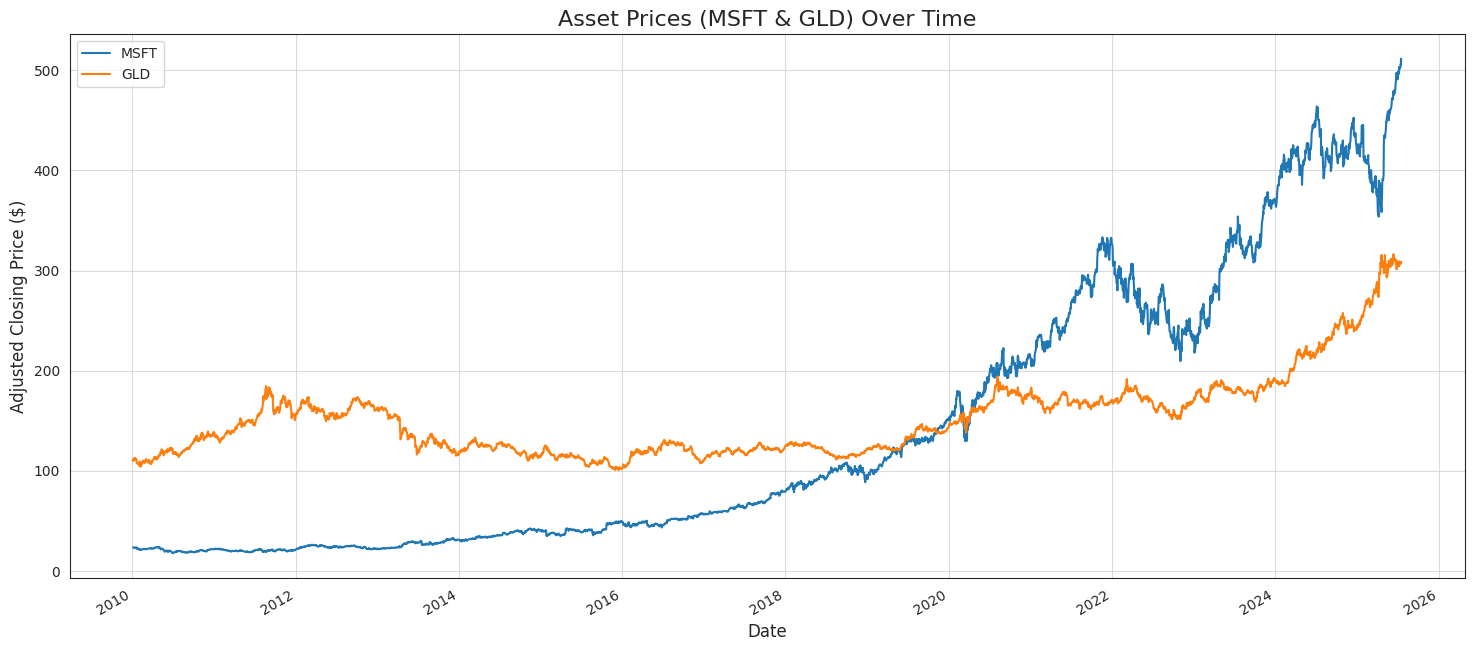

In [36]:
plt.figure(figsize=(18, 8)) # Set a good figure size for presentation
data[['MSFT', 'GLD']].plot(ax=plt.gca()) # Plot directly from the DataFrame
plt.title('Asset Prices (MSFT & GLD) Over Time', fontsize=16) # Add a descriptive title
plt.xlabel('Date', fontsize=12) # Label the x-axis
plt.ylabel('Adjusted Closing Price ($)', fontsize=12) # Label the y-axis
plt.legend(['MSFT', 'GLD'], fontsize=10) # Add a legend for clarity
plt.grid(True, linestyle='-', alpha=0.7) # Add a grid for readability
plt.show() # Display the plot


In [4]:
# Calculate returns
returns = data.pct_change().dropna()
benchmark_returns = benchmark_data.pct_change().dropna()

# Split into training and test sets
train_data = returns[returns.index.year <= 2023]
test_data = returns[returns.index.year >= 2024]

print("\nData Summary:")
print(f"Training period: {train_data.index[0].date()} to {train_data.index[-1].date()} ({len(train_data)} days)")
print(f"Test period: {test_data.index[0].date()} to {test_data.index[-1].date()} ({len(test_data)} days)")


Data Summary:
Training period: 2010-01-05 to 2023-12-29 (3521 days)
Test period: 2024-01-02 to 2025-07-18 (387 days)


In [5]:
class MinimumVariancePortfolio:
    def __init__(self, initial_capital=100000, min_weight=0.2, max_weight=0.8, rebalance_freq=21):
        self.cov_model = LedoitWolf()
        self.portfolio_value = initial_capital
        self.min_weight = min_weight
        self.max_weight = max_weight
        self.rebalance_freq = rebalance_freq
        self.days_since_rebalance = 0
        self.current_weights = np.array([0.5, 0.5])  # Initialize with equal weights
        self.history = []
        self.transaction_costs = 0

    def calculate_weights(self, cov_matrix):
        """Calculate constrained minimum variance weights"""
        inv_cov = np.linalg.inv(cov_matrix)
        ones = np.ones(len(cov_matrix))
        weights = inv_cov @ ones / (ones.T @ inv_cov @ ones)

        # Apply constraints and normalize
        weights = np.clip(weights, self.min_weight, self.max_weight)
        return weights / weights.sum()

    def rebalance(self, cov_matrix, current_prices):
        """Execute rebalancing with transaction costs"""
        new_weights = self.calculate_weights(cov_matrix)

        # Apply transaction costs (0.1%)
        if self.current_weights is not None:
            turnover = np.abs(new_weights - self.current_weights).sum()
            cost = self.portfolio_value * 0.001 * turnover
            self.portfolio_value -= cost
            self.transaction_costs += cost

        self.current_weights = new_weights
        self.days_since_rebalance = 0
        return self.portfolio_value * new_weights / current_prices

    def update(self, returns):
        """Update portfolio value with daily returns"""
        if self.current_weights is not None:
            self.portfolio_value *= (1 + (returns * self.current_weights).sum())
        self.days_since_rebalance += 1
        self.history.append(self.portfolio_value)

    def compute_risk(self, cov_matrix, alpha=0.05):
        """Calculate VaR and ES"""
        port_variance = self.current_weights.T @ cov_matrix @ self.current_weights
        port_std = np.sqrt(port_variance)

        var = norm.ppf(alpha, 0, port_std) * self.portfolio_value
        es = (port_std * norm.pdf(norm.ppf(alpha)) / alpha) * self.portfolio_value

        return var, es, port_std

In [6]:
window_size = 180  # 6-month rolling window
portfolio = MinimumVariancePortfolio(min_weight=0.2, max_weight=0.8)

# Store training results
train_results = pd.DataFrame(index=train_data.index[window_size:],
                           columns=['Portfolio Value', 'MSFT Weight', 'GLD Weight',
                                   'VaR', 'ES', 'Portfolio Std'])


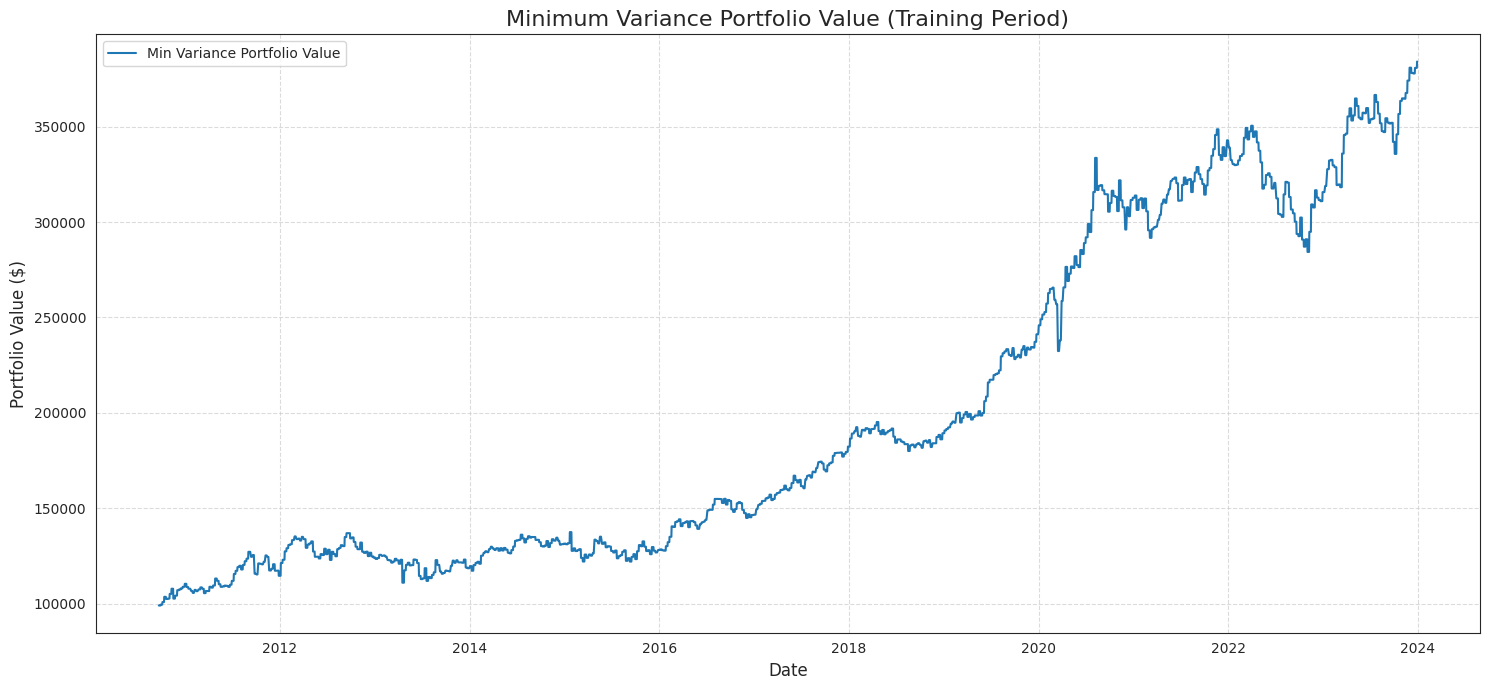

In [44]:
# Assuming train_results DataFrame is already populated from your training loop
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 7))
plt.plot(train_results.index, train_results['Portfolio Value'], label='Min Variance Portfolio Value')
plt.title('Minimum Variance Portfolio Value (Training Period)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Portfolio Value ($)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

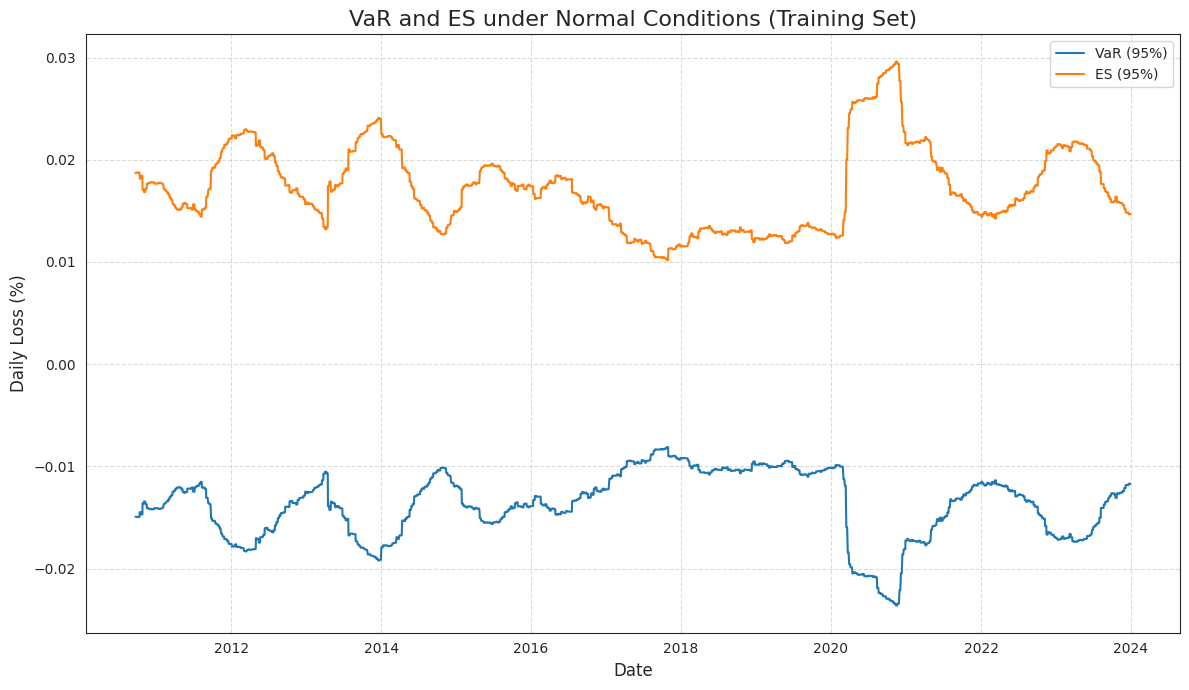

In [45]:
plt.figure(figsize=(12, 7))
plt.plot(train_results.index, train_results['VaR'] / train_results['Portfolio Value'], label='VaR (95%)')
plt.plot(train_results.index, train_results['ES'] / train_results['Portfolio Value'], label='ES (95%)')

plt.title('VaR and ES under Normal Conditions (Training Set)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Loss (%)', fontsize=12) # Label as percentage loss
plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation on y-axis if values are small
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
for i in range(window_size, len(train_data)):
    window_returns = train_data.iloc[i-window_size:i]
    current_returns = train_data.iloc[i]

    # Update covariance matrix
    cov_matrix = portfolio.cov_model.fit(window_returns).covariance_

    # Rebalance if needed
    if portfolio.days_since_rebalance >= portfolio.rebalance_freq:
        current_prices = data.iloc[i]
        portfolio.rebalance(cov_matrix, current_prices)

    # Update portfolio
    portfolio.update(current_returns)

    # Weekly risk metrics
    if i % 5 == 0 or i == len(train_data) - 1:
        var, es, port_std = portfolio.compute_risk(cov_matrix)
        train_results.iloc[i-window_size] = {
            'Portfolio Value': portfolio.portfolio_value,
            'MSFT Weight': portfolio.current_weights[0],
            'GLD Weight': portfolio.current_weights[1],
            'VaR': var,
            'ES': es,
            'Portfolio Std': port_std
        }

train_results = train_results.ffill().dropna()

/tmp/ipython-input-7-2456736026.py:28: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_results = train_results.ffill().dropna()


In [8]:
def generate_stress_scenarios(recent_returns, n_scenarios=5000, stress_factor=2.5):
    """Generate stressed returns with fat tails and correlation shocks"""
    mean = recent_returns.mean().values
    cov = recent_returns.cov().values

    # Create asymmetric stress - higher for negative correlations
    stressed_cov = cov * stress_factor
    stressed_cov = np.where(cov < 0, stressed_cov * 1.5, stressed_cov)

    # Student-t distribution for fat tails (df=3)
    chol = np.linalg.cholesky(stressed_cov)
    t_samples = np.random.standard_t(3, size=(n_scenarios, len(mean)))
    scenarios = mean + np.dot(t_samples, chol.T)

    return scenarios

def stress_test(portfolio, recent_returns, current_weights, n_scenarios=5000):
    scenarios = generate_stress_scenarios(recent_returns, n_scenarios)
    port_returns = scenarios @ current_weights
    var_stressed = np.percentile(port_returns, 5) * portfolio.portfolio_value
    es_stressed = port_returns[port_returns <= np.percentile(port_returns, 5)].mean() * portfolio.portfolio_value
    return var_stressed, es_stressed

In [9]:
# Perform stress test at end of training
recent_returns = train_data.iloc[-window_size:]
current_weights = np.array([train_results['MSFT Weight'].iloc[-1],
                          train_results['GLD Weight'].iloc[-1]])
var_stressed, es_stressed = stress_test(portfolio, recent_returns, current_weights)

print("\nStress Test Results:")
print(f"Normal VaR (95%): ${-train_results['VaR'].iloc[-1]:,.2f}")
print(f"Stressed VaR (95%): ${-var_stressed:,.2f} ({(var_stressed/train_results['VaR'].iloc[-1]-1):.1%} higher)")
print(f"Normal ES (95%): ${-train_results['ES'].iloc[-1]:,.2f}")
print(f"Stressed ES (95%): ${-es_stressed:,.2f} ({(es_stressed/train_results['ES'].iloc[-1]-1):.1%} higher)")



Stress Test Results:
Normal VaR (95%): $4,503.45
Stressed VaR (95%): $10,070.75 (123.6% higher)
Normal ES (95%): $-5,647.51
Stressed ES (95%): $15,226.62 (-369.6% higher)


In [10]:
test_portfolio = MinimumVariancePortfolio(
    initial_capital=train_results['Portfolio Value'].iloc[-1],
    min_weight=0.2,
    max_weight=0.8
)
test_portfolio.current_weights = current_weights

# Initialize benchmark
benchmark_init = benchmark_data.loc[test_data.index[0]]
benchmark_values = 100000 * benchmark_data.loc[test_data.index] / benchmark_init

In [11]:
# Initialize 60/40 benchmark
weights_60_40 = np.array([0.6, 0.4])
sixty_forty_values = (test_data @ weights_60_40 + 1).cumprod() * 100000

# Store test results
test_results = pd.DataFrame(index=test_data.index,
                          columns=['Portfolio Value', 'MSFT Weight', 'GLD Weight',
                                  'VaR', 'ES', 'Stressed VaR', 'Stressed ES',
                                  'Benchmark Value', '60_40_Value'])

test_results['Benchmark Value'] = benchmark_values
test_results['60_40_Value'] = sixty_forty_values

In [12]:
for i in range(len(test_data)):
    available_data = pd.concat([train_data, test_data.iloc[:i+1]])
    if len(available_data) < window_size:
        continue

    window_returns = available_data.iloc[-window_size:]
    current_returns = test_data.iloc[i]

    # Update covariance matrix
    cov_matrix = test_portfolio.cov_model.fit(window_returns).covariance_

    # Monthly rebalancing
    if test_portfolio.days_since_rebalance >= test_portfolio.rebalance_freq:
        current_prices = data.loc[test_data.index[i]]
        test_portfolio.rebalance(cov_matrix, current_prices)

    # Update portfolio
    test_portfolio.update(current_returns)

    # Quarterly stress testing
    if i % 63 == 0 or i == len(test_data) - 1:
        var_stressed, es_stressed = stress_test(test_portfolio, window_returns, test_portfolio.current_weights)

    # Weekly risk metrics
    if i % 5 == 0 or i == len(test_data) - 1:
        var, es, _ = test_portfolio.compute_risk(cov_matrix)
        test_results.iloc[i] = {
            'Portfolio Value': test_portfolio.portfolio_value,
            'MSFT Weight': test_portfolio.current_weights[0],
            'GLD Weight': test_portfolio.current_weights[1],
            'VaR': var,
            'ES': es,
            'Stressed VaR': var_stressed if 'var_stressed' in locals() else np.nan,
            'Stressed ES': es_stressed if 'es_stressed' in locals() else np.nan
        }

test_results = test_results.ffill().dropna()


/tmp/ipython-input-12-3122635493.py:37: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  test_results = test_results.ffill().dropna()


In [13]:
def calculate_performance(prices):
    """Calculate performance metrics from price series"""
    if len(prices) < 2:
        return {
            'Total Return': np.nan,
            'Annualized Return': np.nan,
            'Annualized Vol': np.nan,
            'Sharpe Ratio': np.nan,
            'Max Drawdown': np.nan
        }

    returns = np.diff(prices) / prices[:-1]
    total_return = prices[-1]/prices[0] - 1
    annualized_return = (1 + total_return)**(252/len(prices)) - 1
    annualized_vol = np.std(returns) * np.sqrt(252)
    sharpe = annualized_return / annualized_vol if annualized_vol > 0 else np.nan
    cummax = np.maximum.accumulate(prices)
    max_drawdown = np.max((cummax - prices)/cummax)

    return {
        'Total Return': float(total_return),
        'Annualized Return': float(annualized_return),
        'Annualized Vol': float(annualized_vol),
        'Sharpe Ratio': float(sharpe) if not np.isnan(sharpe) else np.nan,
        'Max Drawdown': float(max_drawdown)
    }

# Calculate performance
portfolio_perf = calculate_performance(test_results['Portfolio Value'].values)
benchmark_perf = calculate_performance(test_results['Benchmark Value'].values)
sixty_forty_perf = calculate_performance(test_results['60_40_Value'].values)

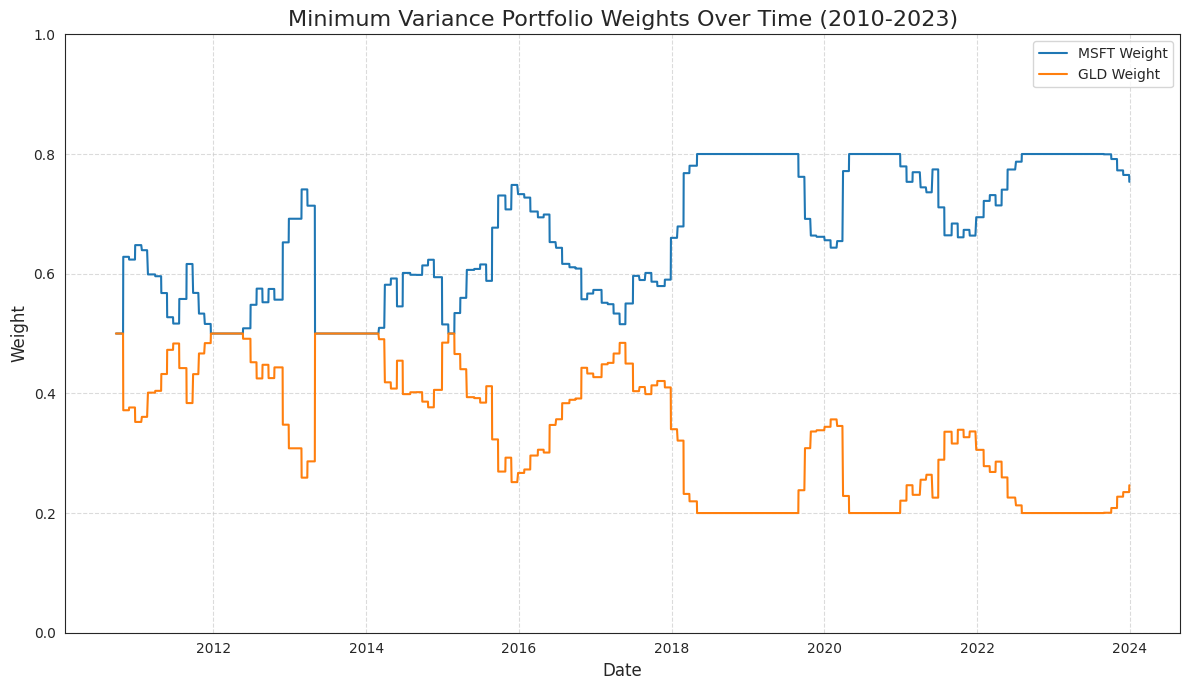

In [37]:
plt.figure(figsize=(12, 7)) # Set a good figure size
plt.plot(train_results.index, train_results['MSFT Weight'], label='MSFT Weight')
plt.plot(train_results.index, train_results['GLD Weight'], label='GLD Weight')
plt.title('Minimum Variance Portfolio Weights Over Time (2010-2023)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Weight', fontsize=12)
plt.ylim(0, 1) # Weights sum to 1, so limit y-axis from 0 to 1
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [14]:
print("\nPerformance Comparison:")
print(f"{'Metric':<20} {'Min Var Portfolio':>18} {'60/40 Portfolio':>18} {'S&P 500':>15}")
metrics = ['Total Return', 'Annualized Return', 'Annualized Vol', 'Sharpe Ratio', 'Max Drawdown']
for metric in metrics:
    p_val = portfolio_perf.get(metric, np.nan)
    s_val = sixty_forty_perf.get(metric, np.nan)
    b_val = benchmark_perf.get(metric, np.nan)

    if isinstance(p_val, (int, float)) and isinstance(s_val, (int, float)) and isinstance(b_val, (int, float)):
        print(f"{metric:<20} {p_val:>18.2%} {s_val:>18.2%} {b_val:>15.2%}")
    else:
        print(f"{metric:<20} {'N/A':>18} {'N/A':>18} {'N/A':>15}")

# Transaction cost analysis
print(f"\nTotal Transaction Costs: ${test_portfolio.transaction_costs:,.2f}")
print(f"Cost as % of Portfolio: {test_portfolio.transaction_costs/test_results['Portfolio Value'].iloc[-1]:.2%}")



Performance Comparison:
Metric                Min Var Portfolio    60/40 Portfolio         S&P 500
Total Return                     54.27%             54.68%          33.13%
Annualized Return                32.72%             32.94%          20.54%
Annualized Vol                   12.85%             14.46%          16.97%
Sharpe Ratio                    254.51%            227.77%         121.06%
Max Drawdown                      5.75%              6.47%          18.90%

Total Transaction Costs: $479.34
Cost as % of Portfolio: 0.08%


In [15]:
def count_violations(values, var_values):
    """Count VaR violations"""
    returns = np.diff(values) / values[:-1]
    var_returns = var_values[1:] / values[:-1]
    violations = returns < var_returns
    return np.sum(violations), len(violations)

normal_violations, n_normal = count_violations(
    test_results['Portfolio Value'].values,
    test_results['VaR'].values
)
stressed_violations, n_stressed = count_violations(
    test_results['Portfolio Value'].values,
    test_results['Stressed VaR'].values
)

print("\nBacktesting Results:")
print(f"Normal VaR violations: {normal_violations} ({normal_violations/n_normal:.1%})")
print(f"Stressed VaR violations: {stressed_violations} ({stressed_violations/n_stressed:.1%})")
print(f"Expected violations: {0.05*n_normal:.1f}")


Backtesting Results:
Normal VaR violations: 13 (3.4%)
Stressed VaR violations: 3 (0.8%)
Expected violations: 19.2


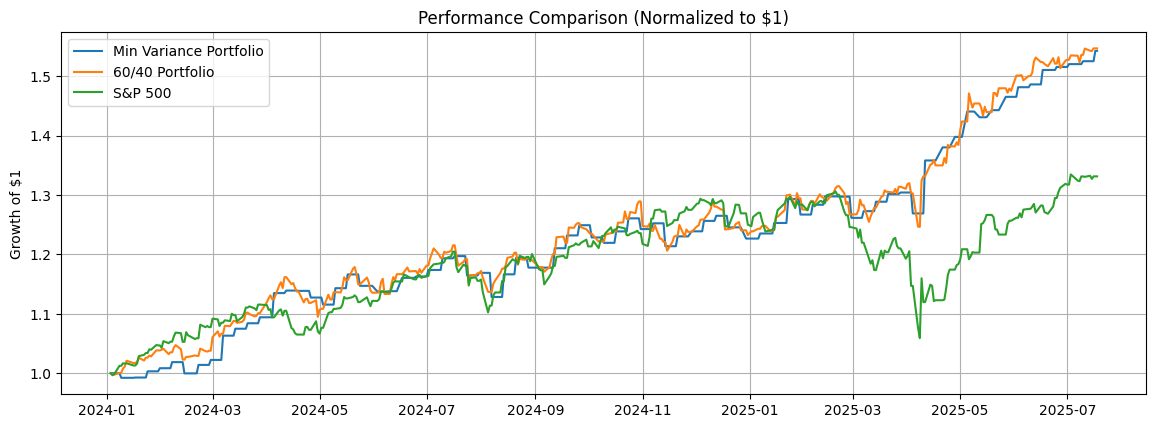

In [16]:
plt.figure(figsize=(14, 16))

# 1. Performance Comparison Plot
plt.subplot(3, 1, 1)
plt.plot(test_results.index,
         test_results['Portfolio Value']/test_results['Portfolio Value'].iloc[0],
         label='Min Variance Portfolio')
plt.plot(test_results.index,
         test_results['60_40_Value']/test_results['60_40_Value'].iloc[0],
         label='60/40 Portfolio')
plt.plot(test_results.index,
         test_results['Benchmark Value']/test_results['Benchmark Value'].iloc[0],
         label='S&P 500')
plt.title('Performance Comparison (Normalized to $1)')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)

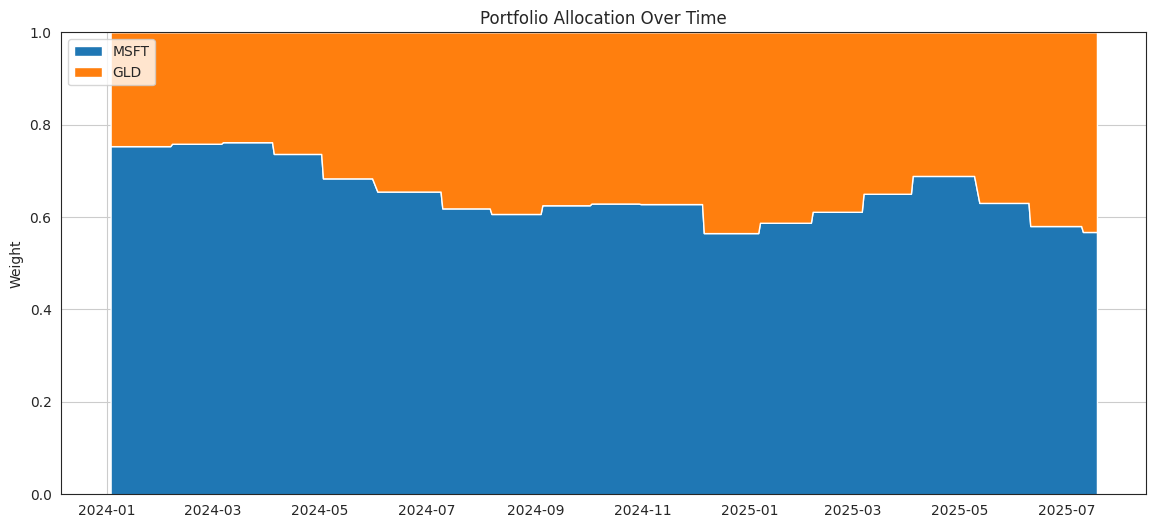

In [40]:
plt.figure(figsize=(14, 6)) # Set a good figure size
# Ensure numeric conversion and handle all edge cases
msft_weights = pd.to_numeric(test_results['MSFT Weight'], errors='coerce').fillna(0.5).to_numpy()
gld_weights = pd.to_numeric(test_results['GLD Weight'], errors='coerce').fillna(0.5).to_numpy()

# Verify shapes match
if len(msft_weights) == len(gld_weights) == len(test_results.index):
    plt.stackplot(test_results.index.values.astype('datetime64[D]'),  # Convert index to proper datetime
                 msft_weights,
                 gld_weights,
                 labels=['MSFT', 'GLD'])
    plt.title('Portfolio Allocation Over Time')
    plt.ylabel('Weight')
    plt.ylim(0, 1)
    plt.legend(loc='upper left')
    plt.grid(True)
else:
    print("Warning: Could not plot allocation - data length mismatch")

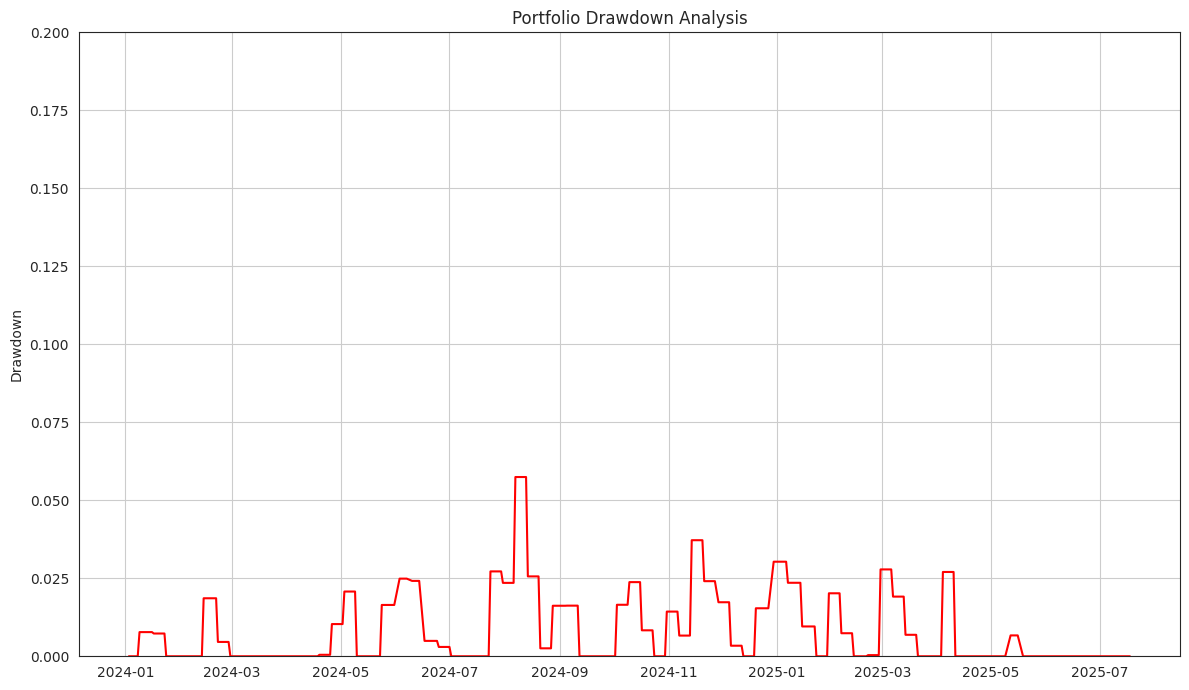

In [39]:
# 3. Drawdown Analysis Plot
plt.figure(figsize=(12, 7)) # Set a good figure size
cummax = test_results['Portfolio Value'].cummax()
drawdown = (cummax - test_results['Portfolio Value']) / cummax
plt.plot(test_results.index, drawdown, label='Portfolio Drawdown', color='red')
plt.title('Portfolio Drawdown Analysis')
plt.ylabel('Drawdown')
plt.ylim(0, 0.2)
plt.grid(True)

plt.tight_layout()
plt.show()

In [19]:
if not test_results.empty:
    for year in test_results.index.year.unique():
        year_data = test_results[test_results.index.year == year]
        if len(year_data) < 20:
            continue

        cummax = year_data['Portfolio Value'].cummax()
        drawdown = (cummax - year_data['Portfolio Value']) / cummax
        max_dd = drawdown.max()

        print(f"\n{year} Analysis:")
        print(f"Max Drawdown: {max_dd:.1%}")
        print(f"Avg Normal VaR: ${-year_data['VaR'].mean():,.0f}")
        print(f"Avg Stressed VaR: ${-year_data['Stressed VaR'].mean():,.0f}")
        print(f"60/40 Portfolio Return: {(year_data['60_40_Value'].iloc[-1]/year_data['60_40_Value'].iloc[0]-1):.1%}")


2024 Analysis:
Max Drawdown: 5.7%
Avg Normal VaR: $5,417
Avg Stressed VaR: $11,535
60/40 Portfolio Return: 23.2%

2025 Analysis:
Max Drawdown: 2.8%
Avg Normal VaR: $8,063
Avg Stressed VaR: $15,881
60/40 Portfolio Return: 24.8%


/tmp/ipython-input-47-525390657.py:40: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_results = train_results.ffill().dropna()


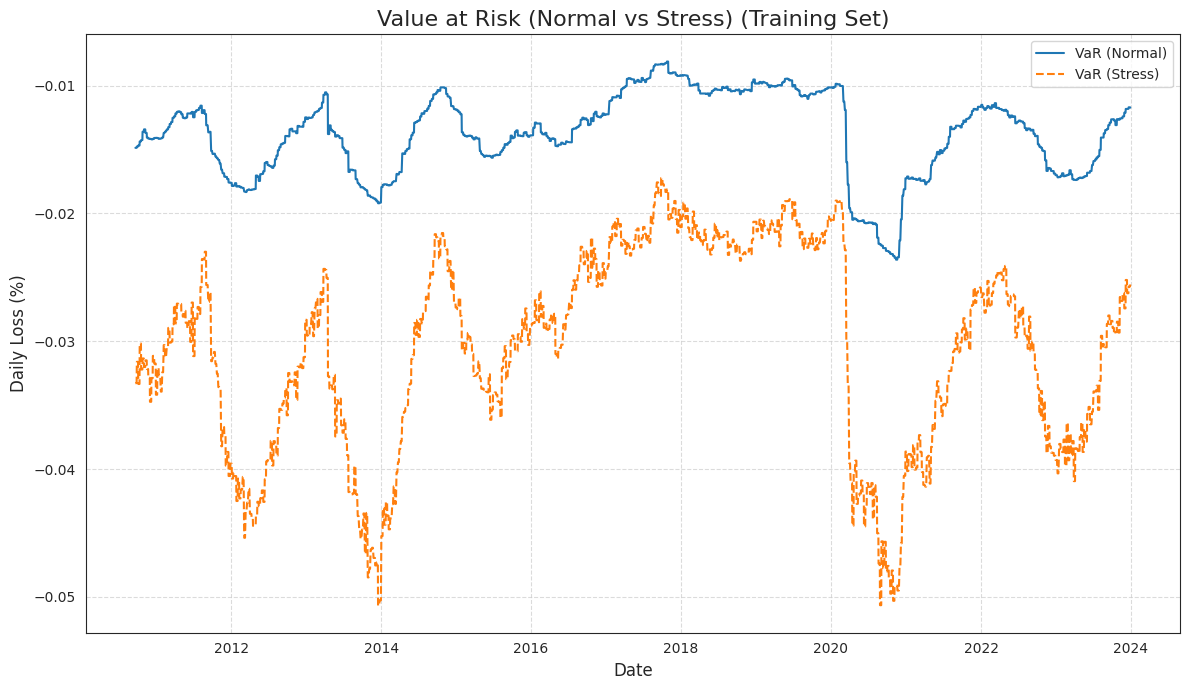

In [47]:

# Ensure train_results has a 'Stressed VaR' column
train_results = pd.DataFrame(index=train_data.index[window_size:],
                             columns=['Portfolio Value', 'MSFT Weight', 'GLD Weight',
                                      'VaR', 'ES', 'Portfolio Std', 'Stressed VaR', 'Stressed ES']) # Added Stressed VaR, Stressed ES

# ... (existing MinimumVariancePortfolio class and initializations) ...

# Inside your training loop (where you calculate VaR and ES):
for i in range(window_size, len(train_data)):
    window_returns = train_data.iloc[i-window_size:i]
    current_returns = train_data.iloc[i]

    cov_matrix = portfolio.cov_model.fit(window_returns).covariance_

    if portfolio.days_since_rebalance >= portfolio.rebalance_freq:
        current_prices = data.iloc[i]
        portfolio.rebalance(cov_matrix, current_prices)

    portfolio.update(current_returns)

    # Calculate Normal VaR/ES weekly
    if i % 5 == 0 or i == len(train_data) - 1:
        var, es, port_std = portfolio.compute_risk(cov_matrix)

        # Calculate Stressed VaR/ES less frequently, e.g., monthly or quarterly
        # For this plot, you might want to calculate it weekly as well for a smoother line
        var_stressed, es_stressed = stress_test(portfolio, window_returns, portfolio.current_weights)

        train_results.loc[train_data.index[i]] = {
            'Portfolio Value': portfolio.portfolio_value,
            'MSFT Weight': portfolio.current_weights[0],
            'GLD Weight': portfolio.current_weights[1],
            'VaR': var,
            'ES': es,
            'Portfolio Std': port_std,
            'Stressed VaR': var_stressed, # Store stressed VaR
            'Stressed ES': es_stressed   # Store stressed ES
        }

train_results = train_results.ffill().dropna()

# --- Plotting Code for VaR (Normal VS Stress) ---

plt.figure(figsize=(12, 7))
# Plot VaR as a percentage of portfolio value, similar to the colleague's graph
plt.plot(train_results.index, train_results['VaR'] / train_results['Portfolio Value'], label='VaR (Normal)')
plt.plot(train_results.index, train_results['Stressed VaR'] / train_results['Portfolio Value'], label='VaR (Stress)', linestyle='--')

plt.title('Value at Risk (Normal vs Stress) (Training Set)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Loss (%)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

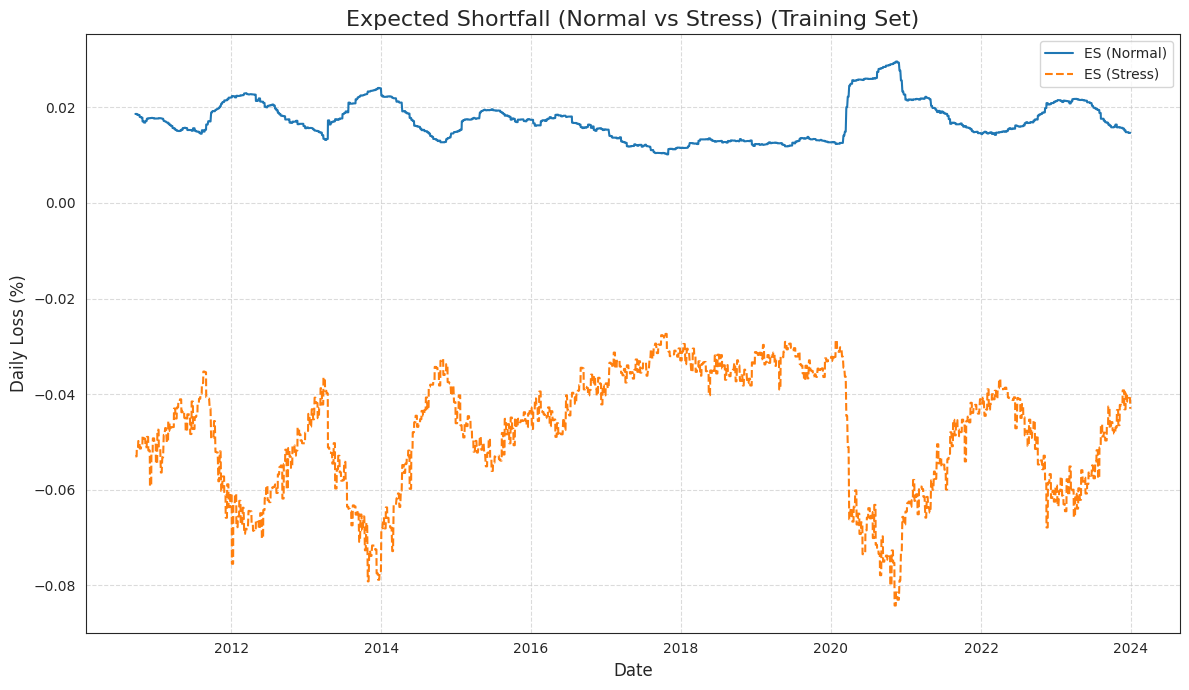

In [48]:
plt.figure(figsize=(12, 7))
# Plot ES as a percentage of portfolio value, similar to the colleague's graph
plt.plot(train_results.index, train_results['ES'] / train_results['Portfolio Value'], label='ES (Normal)')
plt.plot(train_results.index, train_results['Stressed ES'] / train_results['Portfolio Value'], label='ES (Stress)', linestyle='--')

plt.title('Expected Shortfall (Normal vs Stress) (Training Set)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Daily Loss (%)', fontsize=12)
plt.ticklabel_format(style='plain', axis='y') # Prevent scientific notation
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


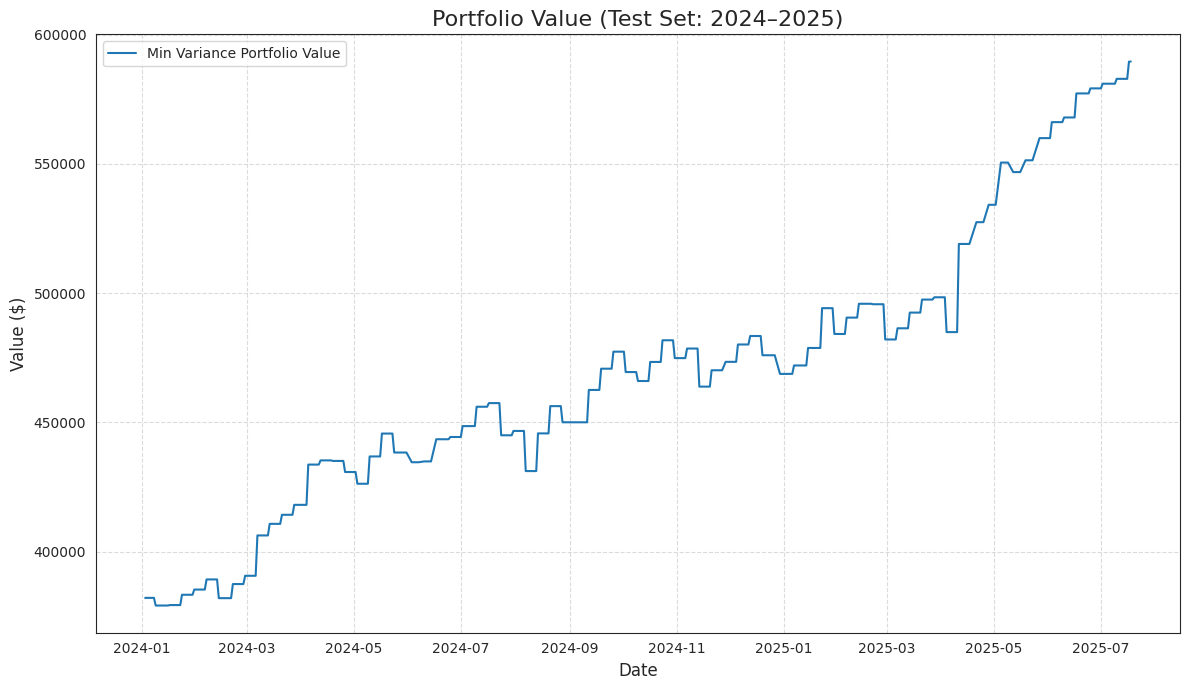

In [50]:
plt.figure(figsize=(12, 7))
plt.plot(test_results.index, test_results['Portfolio Value'], label='Min Variance Portfolio Value')
plt.title('Portfolio Value (Test Set: 2024–2025)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value ($)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
